In [ ]:
!wget -nc -O ffhq256-1k-validation.zip 'https://www.dropbox.com/scl/fi/pppstbdsf0em6o0qscruc/ffhq256-1k-validation.zip?rlkey=xl7nwv2nxb6yvsirr3wad77hm'
!unzip -nq ffhq256-1k-validation.zip -d images
!rm ffhq256-1k-validation.zip


In [18]:
!wget -nc -O ffhq_10m.pt 'https://www.dropbox.com/scl/fi/pq72vxzxcbygieq5z4gvf/ffhq_10m.pt?rlkey=5sxdj6r4o9f7b7bbp5fxg2f5r' 


DEBUG output created by Wget 1.21.1 on linux-gnu.

Reading HSTS entries from /users/eleves-b/2020/damien.vilcocq/.wget-hsts
URI encoding = ‘UTF-8’
--2024-03-23 17:24:06--  https://www.dropbox.com/scl/fi/pq72vxzxcbygieq5z4gvf/ffhq_10m.pt?rlkey=5sxdj6r4o9f7b7bbp5fxg2f5r
Certificates loaded: 354
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Caching www.dropbox.com => 162.125.67.18 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
Created socket 4.
Releasing 0x0000558e134509a0 (new refcount 1).

---request begin---
GET /scl/fi/pq72vxzxcbygieq5z4gvf/ffhq_10m.pt?rlkey=5sxdj6r4o9f7b7bbp5fxg2f5r HTTP/1.1
User-Agent: Wget/1.21.1
Accept: */*
Accept-Encoding: identity
Host: www.dropbox.com
Connection: Keep-Alive

---request end---
HTTP request sent, awaiting response... 
---response begin---
HTTP/1.1 302 Found
Content-Type: text/html; charset=utf-8
Location: https://ucd51c155713d6f89d13ce033766.

In [1]:
import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from dps.guided_diffusion.unet import create_model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda:0


In [10]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

cuda:0
original image 00012.png


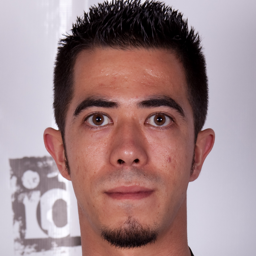

noisy measurement


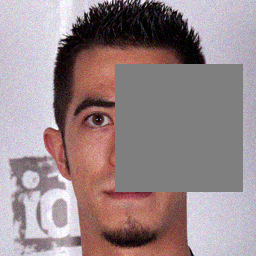

torch.Size([1, 3, 256, 256])


In [13]:
h = 256
w = 256
hcrop, wcrop = h//2, w//2
corner_top, corner_left = h//4, int(0.45*w)
mask = torch.ones((1,3,256, 256), device=device)
mask[:,:,corner_top:corner_top+hcrop,corner_left:corner_left+wcrop] = 0

def linear_operator(x):
  x = x*mask
  return(x)

idx = 12
x_true_pil = Image.open('images/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)
print(x_true.device)
print("original image", str(idx).zfill(5)+'.png')
display_as_pilimg(x_true)

sigma_noise = 2*10/255

y = linear_operator(x_true.clone()) + sigma_noise * mask * torch.randn_like(x_true)
print("noisy measurement")
display_as_pilimg(y);

print(y.size())


In [14]:
from ddrm.functions.svd_replacement import Inpainting
mask=mask.squeeze()[0].flatten()
missing_r = torch.nonzero(mask == 0).long().reshape(-1)*3
missing_g = missing_r + 1
missing_b = missing_g + 1
missing = torch.cat([missing_r, missing_g, missing_b], dim=0)
H_funcs = Inpainting(3, 256, missing, device)

In [15]:
y_0 = H_funcs.H(x_true)

## Load DDPM U-Net

In [19]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': 'ffhq_10m.pt'}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();

In [21]:
from ddrm.functions.denoising import efficient_generalized_steps
import torch
from tqdm import tqdm
import torchvision.utils as tvu
import os

class DDRM:
    def __init__(self, model):
        self.num_timesteps = 1000
        self.reversed_time_steps = np.arange(self.num_timesteps)[::-1]
        beta_start = 0.0001
        beta_end = 0.02
        betas = np.linspace(
            beta_start, beta_end, self.num_timesteps, dtype=np.float64
        )
        betas = self.betas = torch.from_numpy(betas).float().to(device)
        self.num_timesteps = betas.shape[0]

        alphas = 1.0 - betas
        alphas_cumprod = alphas.cumprod(dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0
        )
        self.alphas_cumprod_prev = alphas_cumprod_prev
        self.model = model
        self.imgshape = (1,3,256,256)


    def compute_alpha(self,beta, t):
        beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
        a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
        return a

    def efficient_generalized_steps(self,x, seq, model, b, H_funcs, y_0, sigma_0, etaB, etaA, etaC, cls_fn=None, classes=None):
        with torch.no_grad():
            #setup vectors used in the algorithm
            singulars = H_funcs.singulars()
            Sigma = torch.zeros(x.shape[1]*x.shape[2]*x.shape[3], device=x.device)
            Sigma[:singulars.shape[0]] = singulars
            U_t_y = H_funcs.Ut(y_0)
            Sig_inv_U_t_y = U_t_y / singulars[:U_t_y.shape[-1]]

            #initialize x_T as given in the paper
            largest_alphas = self.compute_alpha(b, (torch.ones(x.size(0)) * seq[-1]).to(x.device).long())
            largest_sigmas = (1 - largest_alphas).sqrt() / largest_alphas.sqrt()
            large_singulars_index = torch.where(singulars * largest_sigmas[0, 0, 0, 0] > sigma_0)
            inv_singulars_and_zero = torch.zeros(x.shape[1] * x.shape[2] * x.shape[3]).to(singulars.device)
            inv_singulars_and_zero[large_singulars_index] = sigma_0 / singulars[large_singulars_index]
            inv_singulars_and_zero = inv_singulars_and_zero.view(1, -1)     

            # implement p(x_T | x_0, y) as given in the paper
            # if eigenvalue is too small, we just treat it as zero (only for init) 
            init_y = torch.zeros(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]).to(x.device)
            init_y[:, large_singulars_index[0]] = U_t_y[:, large_singulars_index[0]] / singulars[large_singulars_index].view(1, -1)
            init_y = init_y.view(*x.size())
            remaining_s = largest_sigmas.view(-1, 1) ** 2 - inv_singulars_and_zero ** 2
            remaining_s = remaining_s.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3]).clamp_min(0.0).sqrt()
            init_y = init_y + remaining_s * x
            init_y = init_y / largest_sigmas
            
            #setup iteration variables
            x = H_funcs.V(init_y.view(x.size(0), -1)).view(*x.size())
            n = x.size(0)
            seq_next = [-1] + list(seq[:-1])
            x0_preds = []
            xs = [x]

            #iterate over the timesteps
            for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
                t = (torch.ones(n) * i).to(x.device)
                next_t = (torch.ones(n) * j).to(x.device)
                at = self.compute_alpha(b, t.long())
                at_next = self.compute_alpha(b, next_t.long())
                xt = xs[-1].to('cuda')
                if cls_fn == None:
                    et = model(xt, t)
                else:
                    et = model(xt, t, classes)
                    et = et[:, :3]
                    et = et - (1 - at).sqrt()[0,0,0,0] * cls_fn(x,t,classes)
                
                if et.size(1) == 6:
                    et = et[:, :3]
                
                x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

                #variational inference conditioned on y
                sigma = (1 - at).sqrt()[0, 0, 0, 0] / at.sqrt()[0, 0, 0, 0]
                sigma_next = (1 - at_next).sqrt()[0, 0, 0, 0] / at_next.sqrt()[0, 0, 0, 0]
                xt_mod = xt / at.sqrt()[0, 0, 0, 0]
                V_t_x = H_funcs.Vt(xt_mod)
                SVt_x = (V_t_x * Sigma)[:, :U_t_y.shape[1]]
                V_t_x0 = H_funcs.Vt(x0_t)
                SVt_x0 = (V_t_x0 * Sigma)[:, :U_t_y.shape[1]]

                falses = torch.zeros(V_t_x0.shape[1] - singulars.shape[0], dtype=torch.bool, device=xt.device)
                cond_before_lite = singulars * sigma_next > sigma_0
                cond_after_lite = singulars * sigma_next < sigma_0
                cond_before = torch.hstack((cond_before_lite, falses))
                cond_after = torch.hstack((cond_after_lite, falses))

                std_nextC = sigma_next * etaC
                sigma_tilde_nextC = torch.sqrt(sigma_next ** 2 - std_nextC ** 2)

                std_nextA = sigma_next * etaA
                sigma_tilde_nextA = torch.sqrt(sigma_next**2 - std_nextA**2)
                
                diff_sigma_t_nextB = torch.sqrt(sigma_next ** 2 - sigma_0 ** 2 / singulars[cond_before_lite] ** 2 * (etaB ** 2))

                #missing pixels
                Vt_xt_mod_next = V_t_x0 + sigma_tilde_nextC * H_funcs.Vt(et) + std_nextC * torch.randn_like(V_t_x0)

                #less noisy than y (after)
                Vt_xt_mod_next[:, cond_after] = \
                    V_t_x0[:, cond_after] + sigma_tilde_nextA * ((U_t_y - SVt_x0) / sigma_0)[:, cond_after_lite] + std_nextA * torch.randn_like(V_t_x0[:, cond_after])
                
                #noisier than y (before)
                Vt_xt_mod_next[:, cond_before] = \
                    (Sig_inv_U_t_y[:, cond_before_lite] * etaB + (1 - etaB) * V_t_x0[:, cond_before] + diff_sigma_t_nextB * torch.randn_like(U_t_y)[:, cond_before_lite])

                #aggregate all 3 cases and give next prediction
                xt_mod_next = H_funcs.V(Vt_xt_mod_next)
                xt_next = (at_next.sqrt()[0, 0, 0, 0] * xt_mod_next).view(*x.shape)

                x0_preds.append(x0_t.to('cpu'))
                xs.append(xt_next.to('cpu'))


        return xs, x0_preds

    def sample_image(self, x, model, H_funcs, y_0, sigma_0, eta, etaB, skip=1, last=True, cls_fn=None, classes=None):
            seq = range(0, self.num_timesteps, skip)
            
            x = self.efficient_generalized_steps(x, seq, model, self.betas, H_funcs, y_0, sigma_0, \
                etaB=etaB, etaA=eta, etaC=eta, cls_fn=cls_fn, classes=classes)
            if last:
                x = x[0][-1]
            return x

In [22]:
ddrm=DDRM(model)

In [23]:
x_reconstructed=ddrm.sample_image(x_true, model, H_funcs, y_0, 10, 0.85, 1, skip=1, last=True, cls_fn=None, classes=None)

1000it [00:29, 34.33it/s]


In [33]:
x_reconstructed.shape

torch.Size([1, 3, 256, 256])

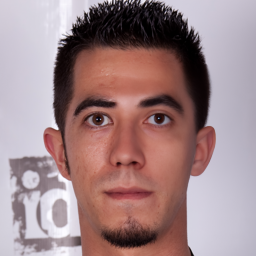

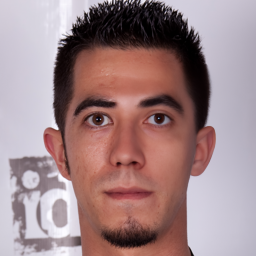

In [24]:
display_as_pilimg(x_reconstructed)